В данной работе мы с вами попробуем применить рекуррентные сети к задаче предсказания цены акций компании Microsoft.
    
Давайте убедимся, что у нас установлены все необходимые библиотеки.

In [ ]:
!pip install numpy matplotlib tensorflow --q

Для воспроизводимости зафиксируем генераторы случайных чисел.

In [ ]:
from tensorflow.python.keras import backend as K

seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

Импортируем все необходимые библиотеки.

In [ ]:
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(
    style="whitegrid",
    font_scale=0.8,
    rc={
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'legend.fontsize': 10,
        'grid.color': '#e5e5e5',
        'grid.linestyle': '--',
        'grid.linewidth': 0.7,
        'axes.grid': True,
        'figure.autolayout': True,
        'figure.figsize': (8, 4)
       }
)

Для начала нам необходимо прочитать набор данных. Вместе с данным ноутбуком вы найдете файл MSFT_corrupted.csv. Прочитайте и запишите его в фрейм.

In [ ]:
df_dirty = pd.read_csv('MSFT_corrupted.csv')

Давайте выведем первые несколько строк файла.

In [ ]:
df_dirty.head()

,date,open,high,low,close,volume,Name
0,2015-11-18,53.00,53.98,52.9799,53.85,29710030,MSFT
1,2015-11-19,53.99,54.66,53.7810,53.94,28149228,MSFT
2,2015-11-20,54.25,54.30,53.2650,54.19,37147608,MSFT
3,2015-11-23,54.25,54.46,53.7500,54.19,28235918,MSFT
4,2015-11-24,53.92,54.44,53.5800,54.25,24600043,MSFT


In [ ]:
df_dirty.shape

(559, 7)

Судя по названию файла, в нем могут присутствовать проблемы с данными. Давайте проверим данные на наличие NaN и каким-либо образом восстановим пропущенные значения.

In [ ]:
print(df_dirty.isnull().sum())    # Смотрим, есть ли NaN
df = df_dirty.dropna()            # Если есть - избавляемся от них.
print(df.isnull().sum())          # Смотрим, есть ли теперь NaN

date      0
open      5
high      5
low       5
close     5
volume    0
Name      0
dtype: int64
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


В данной работе мы с вами будем предсказывать стоимость акции на момент закрытия дня (колонка 'close'). Давайте построим график этой колонки.

<Axes: >

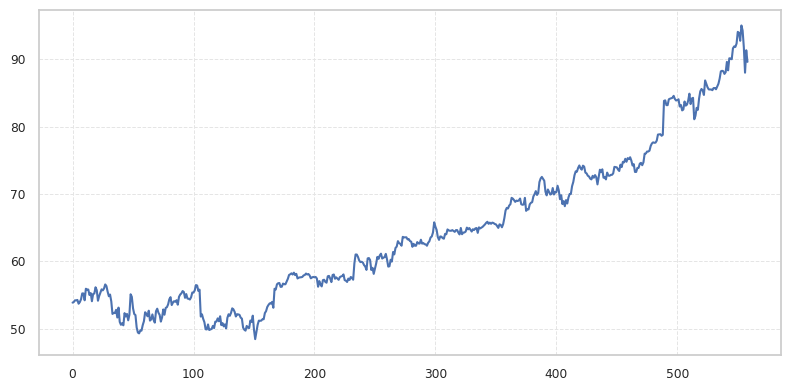

In [ ]:
df['close'].plot()

Оставим в нашем датафрейме только необходимую нам колонку.

In [ ]:
train_df = df[['close']]

Итак, теперь давайте подготовим все необходимое для начала обучения. Зададим глобальные константы - количества эпох, дней и коэффициент деления массива.

In [ ]:
EPOCHS = 10  # количество эпох для обучения
DAYS = 10    # на сколько дней назад смотреть при обучении
SPLIT_VALUE = 0.95  # как делить массив

Определим константу для разделения массива на тренировочную и тестовую части.

In [ ]:
training_data_len = int(len(train_df) * SPLIT_VALUE)
training_data_len

526

Далее с помощью MinMaxScaler'а приведем данные к значениям на отрезке \[0, 1]

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df)

Давайте создадим тренировочный набор данных. Набор будет выглядеть следующим образом: мы будем брать данные за последние X дней и формировать из этого вектор X, а вектор Y будет являться значением стоимости акции на следующий день

In [ ]:
train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = []

for i in range(DAYS, len(train_data)):
    x_train.append(train_data[i-DAYS:i])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

Создадим модель для предсказания. Первым слоем модели должен являться рекуррентный слой с соответствующей формой входного тензора, последним - полносвязный слой с единственным нейроном для предсказания результата.

In [ ]:
model = Sequential([
      LSTM(units=50, input_shape=(DAYS, 1)),
      Dense(units=20),
      Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0082
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8.8109e-04
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.5942e-04
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6.6373e-04
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.8822e-04
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.2756e-04
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.7897e-04
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.4034e-04
Epoch 9/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.1285e-04
Epoch 10/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9382e-04


Для тестирования нашей модели давайте таким же образом сформируем тестовый датасет.

In [ ]:
test_data = scaled_data[training_data_len - DAYS: , :]

x_test = []
y_test = []
for i in range(DAYS, len(test_data)):
    x_test.append(test_data[i-DAYS:i])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

Давайте получим предсказания модели и визуализируем результат.

In [ ]:
predictions = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


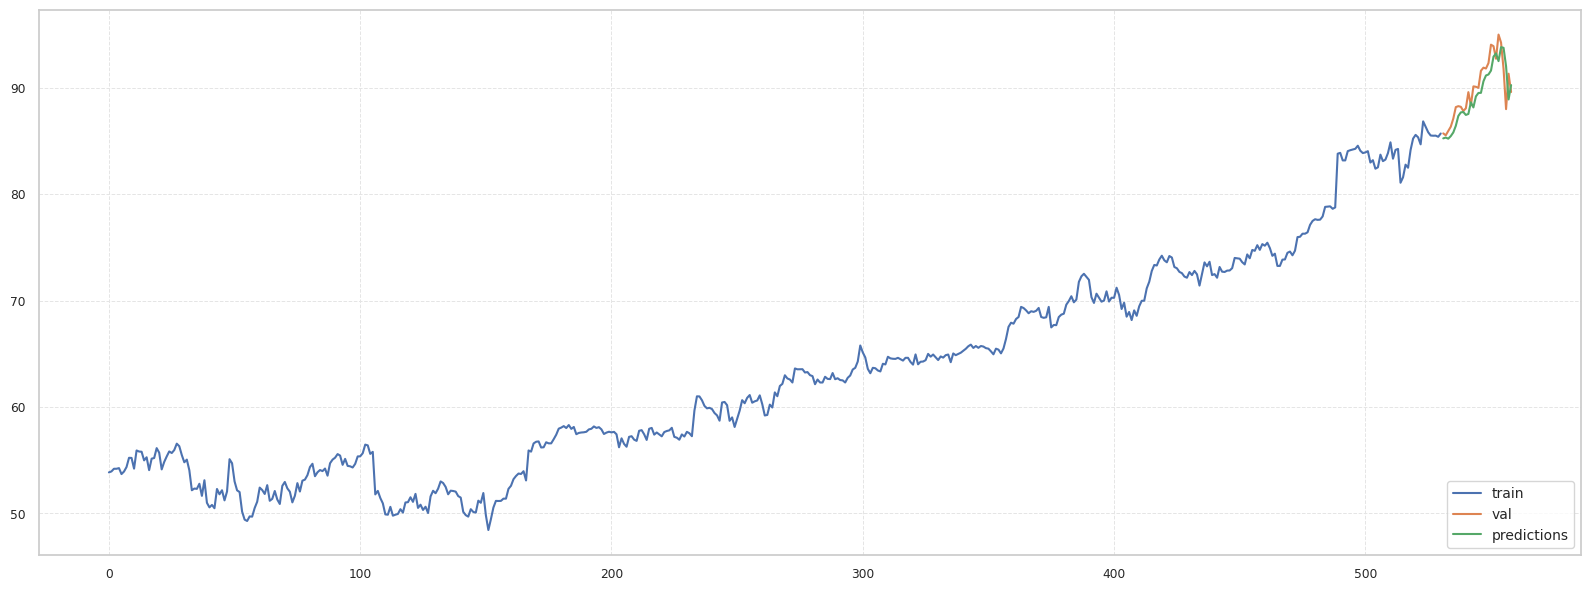

In [ ]:
train = train_df[:training_data_len]
valid = train_df[training_data_len:]
valid['predictions'] = scaler.inverse_transform(predictions)
plt.figure(figsize=(16,6))
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['train', 'val', 'predictions'], loc='lower right')

В качестве бейзлайна (т.е. базовой просто модели для сравнения) выберем step-1 модель. Данная модель для дня i просто берет значение дня i-1. Реализуйте такую модель и в массив prediction_step запишите ее результаты для тех же данных.

In [ ]:
predictions_step = np.array(train_df[training_data_len-1:-1])

In [ ]:
assert predictions.shape == predictions_step.shape

Построим график нашей модели и step-1 модели.

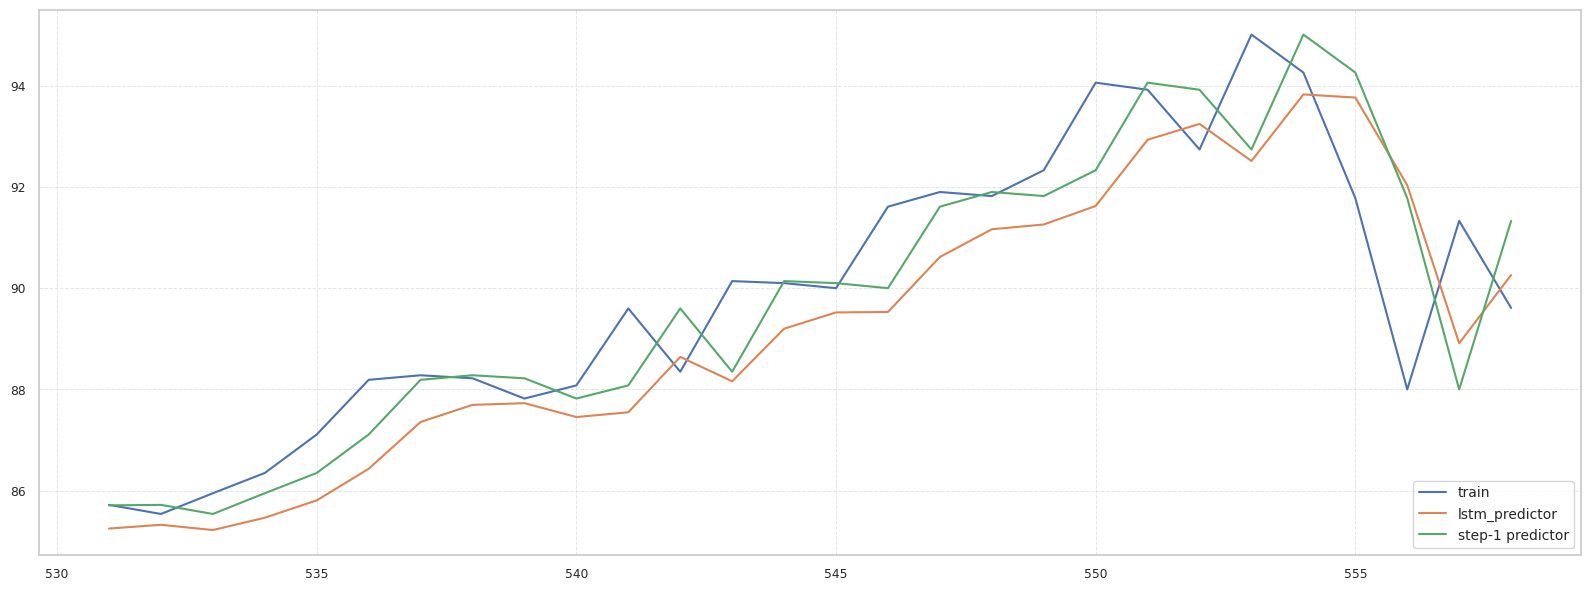

In [ ]:
valid['predictions_step'] = predictions_step
plt.figure(figsize=(16,6))
plt.plot(valid[['close', 'predictions', 'predictions_step']])
plt.legend(['train', 'lstm_predictor', 'step-1 predictor'], loc='lower right')

Удалось ли вам добиться хороших результатов модели? Попробуйте поменять модель нейронной сети, количество слоев, и другие гиперпараметры.  

В процессе тестирования нашей модели мы, тем не менее, использовали "настоящие" данные каждый день для предсказания следующего дня. Давайте попробуем предсказать `len(valid)` дней (т.е. столько же, какова длина массива тестирования) обладая лишь данными на момент дня начала тестирования.  

Т.е. каждый шаг алгоритму необходимо подавать данные за последние DAYS дней, получать его предсказание и записывать в массив с данными как результат дня $i$. На следующем шаге в качестве данных уже будут данные за последние DAYS-1 дней и день $i$, а результат будет записан в день $i+1$ и так далее. Конечным итогом станет то, что мы сможем предсказать движение акций на несколько дней вперед.

In [ ]:
x_test_independent = x_test[0].reshape(1, DAYS, 1)    # взять данные за первый день тестового периода
for i in range(len(valid)):
    result = result = model.predict(x_test_independent[:, -DAYS:, :])    # Получить предсказание модели на данных
    x_test_independent = np.concatenate((x_test_independent, result.reshape(1, 1, 1)), axis=1)  # Добавить полученный result в конец массива x_test_independent, т.о. он будет использован в следующий раз

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

Давайте построим график и посмотрим на результат, а также сравним его с результатом, когда нам известна настоящая информация за указанные дни.

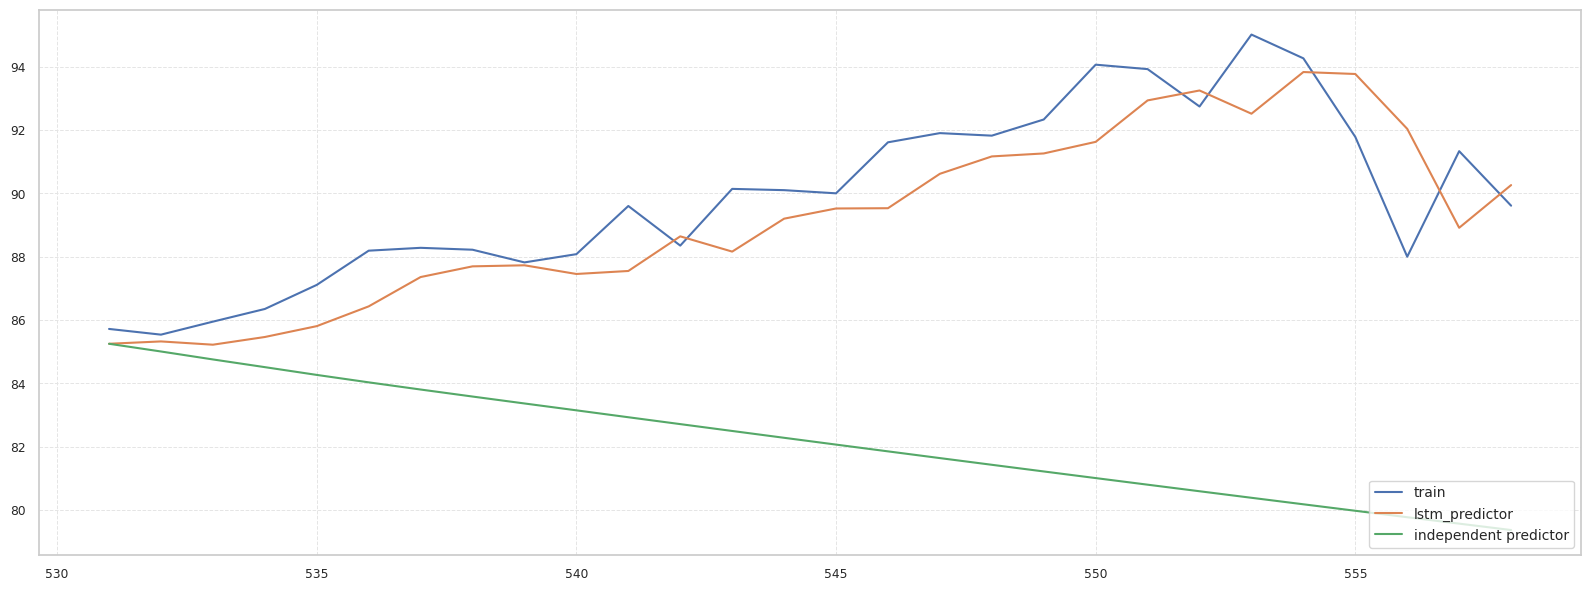

In [ ]:
valid['predictions_indep'] = scaler.inverse_transform(x_test_independent.reshape((-1, 1)))[-len(valid):]
plt.figure(figsize=(16,6))
plt.plot(valid[['close', 'predictions', 'predictions_indep']])
plt.legend(['train', 'lstm_predictor', 'independent predictor'], loc='lower right')

Как можно заметить, результат оставляет желать лучшего. Рекуррентные модели склонны не учитывать тренд и фиксироваться на какой-либо точке.  

Вашим дальнейшим заданием будет следующее.  
В процессе анализа стоимости акций важным параметром является Moving Average - средняя стоимость акций за последние N дней. Вам необходимо вычислить MA за последние 7, 14 и 28 дней и добавить их как отдельные столбцы к тренировочным данным. После чего - натренировать новую нейронную сеть, которая будет получать MA 7, 14, 28 как входные данные и пытаться предсказывать их значения.

В конце точно так же сравните полученный результат с step-1 моделью и попробуйте построить предсказания из единственной точки. Сможет ли Moving Average исправить проблемы тренда за счет более гладких и усредненных результатов?

In [ ]:
train_ma = pd.DataFrame()
train_ma['MA7']  = train_df['close'].rolling(window=7).mean()
train_ma['MA14'] = train_df['close'].rolling(window=14).mean()
train_ma['MA28'] = train_df['close'].rolling(window=28).mean()
# Удаляем строки с NaN (которые появляются из-за недостатка данных для расчета MA)
train_ma = train_ma.dropna()

В train_ma теперь содержатся только строки, где есть полные данные для всех трех MA:

In [ ]:
train_ma

,MA7,MA14,MA28
27,55.471429,55.341429,54.975357
28,55.782857,55.436429,55.063214
29,55.875714,55.451429,55.118214
30,55.797143,55.504286,55.140000
31,55.687143,55.497857,55.170714
...,...,...,...
554,93.448571,91.845714,89.257857
555,93.442857,92.001429,89.482143
556,92.824286,91.976429,89.571071
557,92.434286,92.061429,89.782857


In [ ]:
EPOCHS = 10  # количество эпох для обучения
DAYS = 10    # на сколько дней назад смотреть при обучении
SPLIT_VALUE = 0.95  # как делить массив

Рассчитываем длину обучающего набора данных:

In [ ]:
training_data_len = int(len(train_ma) * SPLIT_VALUE)
training_data_len

500

Масштабируем данные, чтобы привести их в диапазон [0, 1]:

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_ma)

Давайте создадим тренировочный набор данных. Набор будет выглядеть следующим образом: мы будем брать данные за последние X дней и формировать из этого вектор X, а вектор Y будет являться значением стоимости акции на следующий день:

In [ ]:
train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = []

for i in range(DAYS, len(train_data)):
    x_train.append(train_data[i-DAYS:i])
    y_train.append(train_data[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
model_ma = tf.keras.Sequential([
  LSTM(units=50, input_shape=(DAYS, 3)),
  Dense(units=20),
  Dense(units=3) # Выходной слой с 3 нейронами (для MA7, MA14, MA28)
])
# Компилируем модель, задаем оптимизатор и функцию потерь:
model_ma.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
x_train

array([[[0.12638843, 0.12139598, 0.10110512],
        [0.13355242, 0.12366905, 0.10336497],
        [0.13568847, 0.12402796, 0.10477967],
        ...,
        [0.0997371 , 0.11064586, 0.10308019],
        [0.08655932, 0.10751824, 0.10119698],
        [0.07768649, 0.10401463, 0.09895551]],

       [[0.13355242, 0.12366905, 0.10336497],
        [0.13568847, 0.12402796, 0.10477967],
        [0.13388104, 0.12529268, 0.10534003],
        ...,
        [0.08655932, 0.10751824, 0.10119698],
        [0.07768649, 0.10401463, 0.09895551],
        [0.067302  , 0.09767394, 0.09567598]],

       [[0.13568847, 0.12402796, 0.10477967],
        [0.13388104, 0.12529268, 0.10534003],
        [0.13135064, 0.12513886, 0.10613006],
        ...,
        [0.07768649, 0.10401463, 0.09895551],
        [0.067302  , 0.09767394, 0.09567598],
        [0.06092672, 0.09304233, 0.09467466]],

       ...,

       [[0.75810056, 0.78872349, 0.83391973],
        [0.76158396, 0.793338  , 0.8351507 ],
        [0.76592179, 0

In [ ]:
model_ma.fit(x_train, y_train, batch_size=1, epochs=EPOCHS)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0130
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.6494e-04
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.8504e-04
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.8595e-04
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3233e-04
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.8552e-04
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.4431e-04
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.0949e-04
Epoch 9/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7930e-04
Epoch 10/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5439e-04


Для тестирования нашей модели давайте таким же образом сформируем тестовый датасет:

In [ ]:
test_data = scaled_data[training_data_len - DAYS: , :]

x_test = []
y_test = []
for i in range(DAYS, len(test_data)):
    x_test.append(test_data[i-DAYS:i])
    y_test.append(test_data[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
preds = model_ma.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Разделяем обучающие данные на тренировочные и валидационные:

In [ ]:
train = train_ma[:training_data_len]
val = train_ma[training_data_len:]
# Обратное преобразование предсказаний в исходный масштаб и добавление их в валидационный набор
val[['preds7', 'preds14', 'preds28']] = scaler.inverse_transform(preds)

Сравним с бейзлайном:

In [ ]:
val['preds_step_7']  = np.array(train_ma['MA7'][training_data_len-1:-1])
val['preds_step_14'] = np.array(train_ma['MA14'][training_data_len-1:-1])
val['preds_step_28'] = np.array(train_ma['MA28'][training_data_len-1:-1])

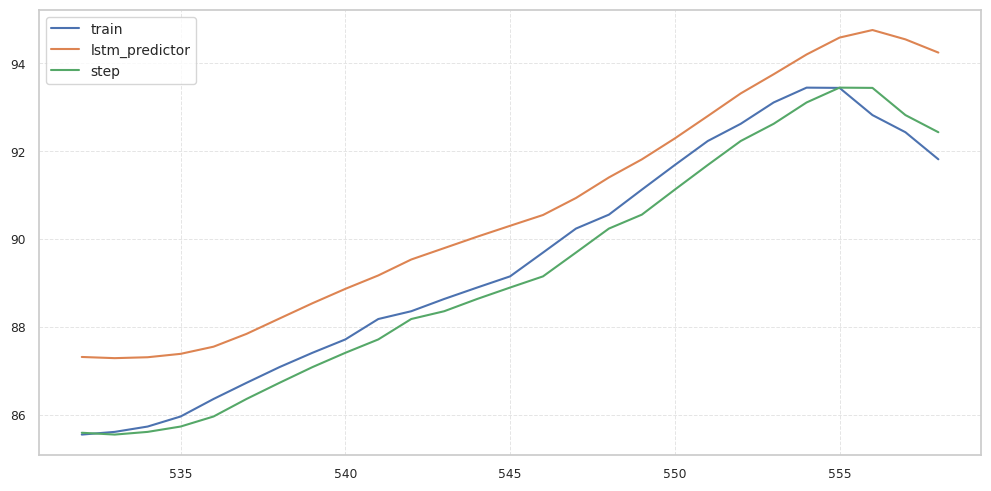

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA7', 'preds7', 'preds_step_7']])
plt.legend(['train', 'lstm_predictor', 'step'])

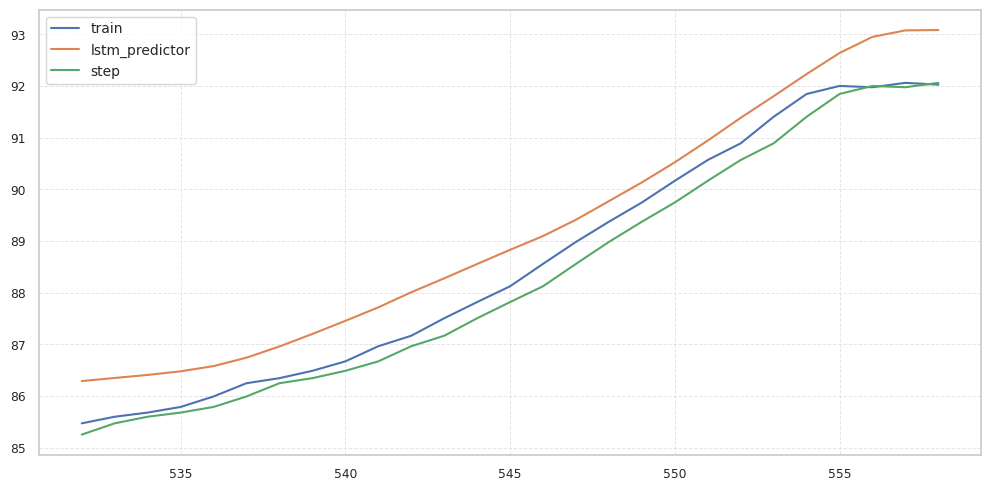

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA14', 'preds14', 'preds_step_14']])
plt.legend(['train', 'lstm_predictor', 'step'])

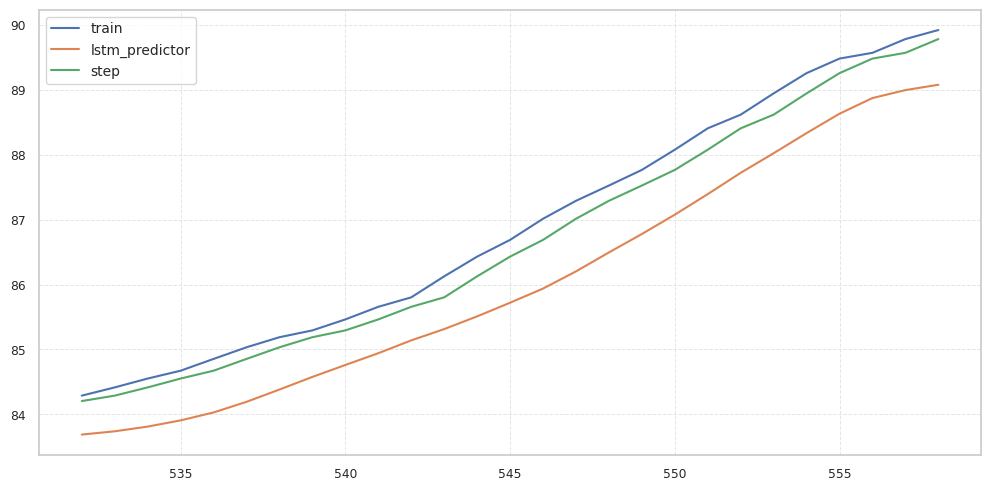

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA28', 'preds28', 'preds_step_28']])
plt.legend(['train', 'lstm_predictor', 'step'])

##### Доп. графики

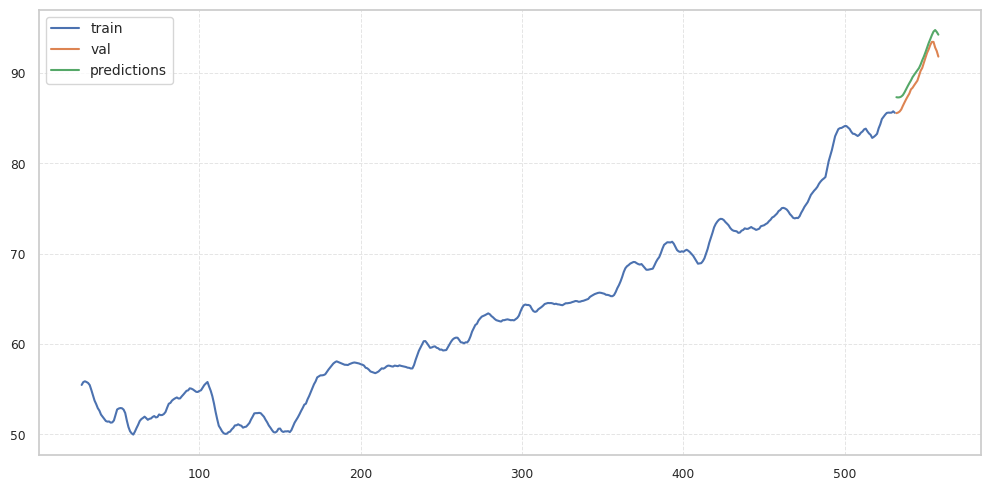

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train['MA7'])
plt.plot(val[['MA7', 'preds7']])
plt.legend(['train', 'val', 'predictions'])

plt.show()

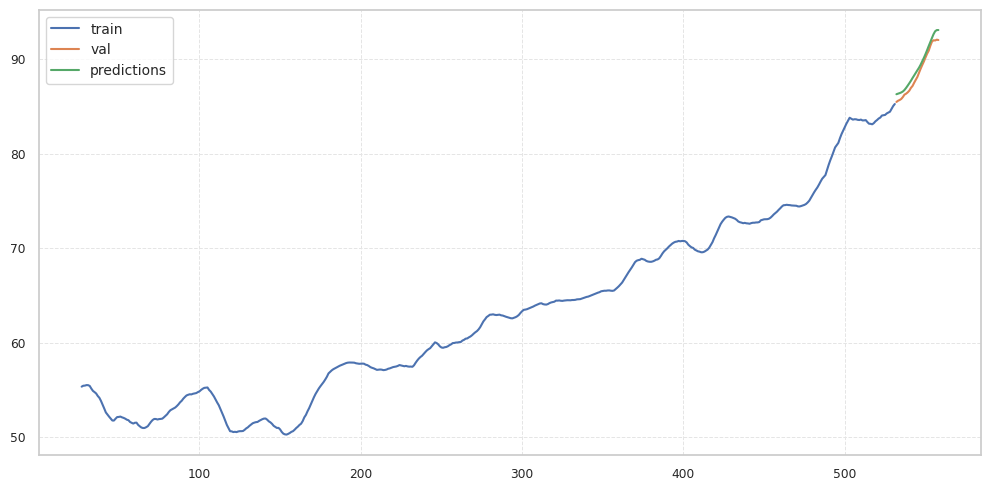

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train['MA14'])
plt.plot(val[['MA14', 'preds14']])
plt.legend(['train', 'val', 'predictions'])

plt.show()

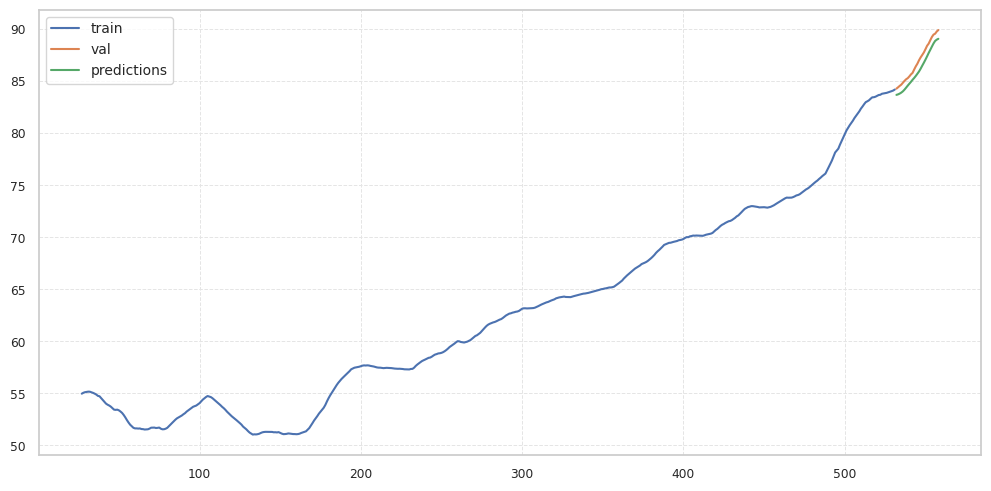

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train['MA28'])
plt.plot(val[['MA28', 'preds28']])
plt.legend(['train', 'val', 'predictions'])

plt.show()

##### Построим предсказания из одной точки

In [ ]:
x_test_one_point = x_test[0].reshape(1, DAYS, 3)  # взять данные за первый день тестового периода
for i in range(len(val)):
    result = model_ma.predict(x_test_one_point[:, -DAYS:, :]) # Получить предсказание модели на данных
    x_test_one_point = np.concatenate((x_test_one_point, result.reshape(1, 1, 3)), axis=1)  # Добавить полученный result в конец массива x_test_independent, т.о. он будет использован в следующий раз

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [ ]:
scaler.inverse_transform(x_test_one_point.reshape((-1, 3)))[-len(valid):].shape

(28, 3)

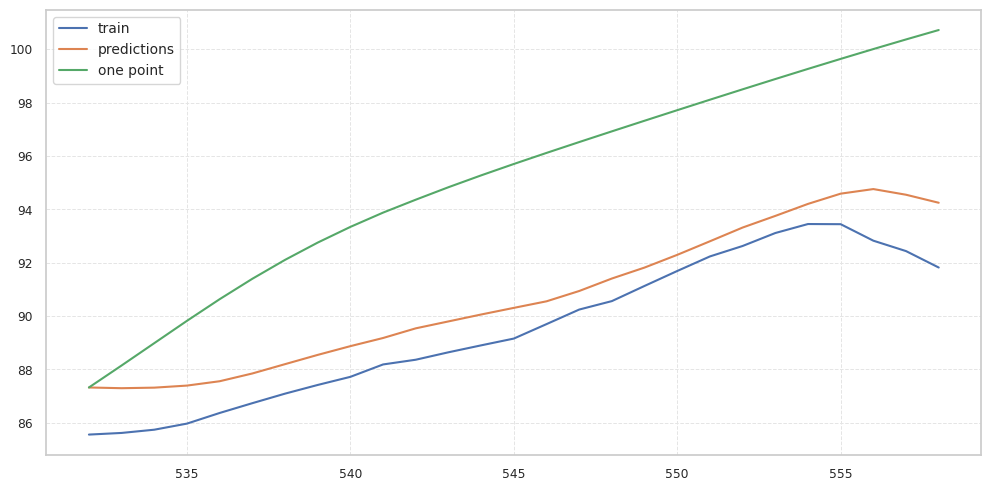

In [ ]:
val[['preds_1_7', 'preds_1_14', 'preds_1_28']] = scaler.inverse_transform(x_test_one_point.reshape((-1, 3)))[-len(val):]

plt.figure(figsize=(10,5))
plt.plot(val[['MA7', 'preds7', 'preds_1_7']])
plt.legend(['train', 'predictions', 'one point'])
plt.show()

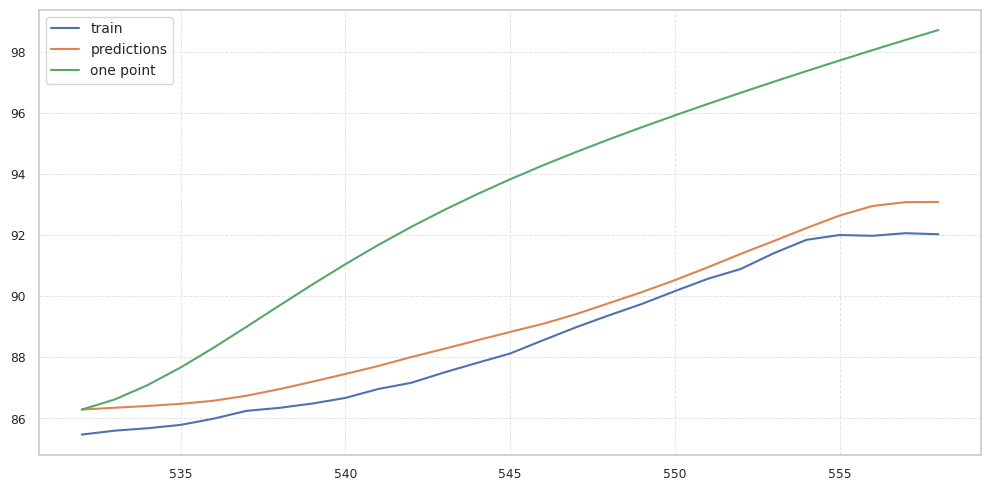

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA14', 'preds14', 'preds_1_14']])
plt.legend(['train', 'predictions', 'one point'])
plt.show()

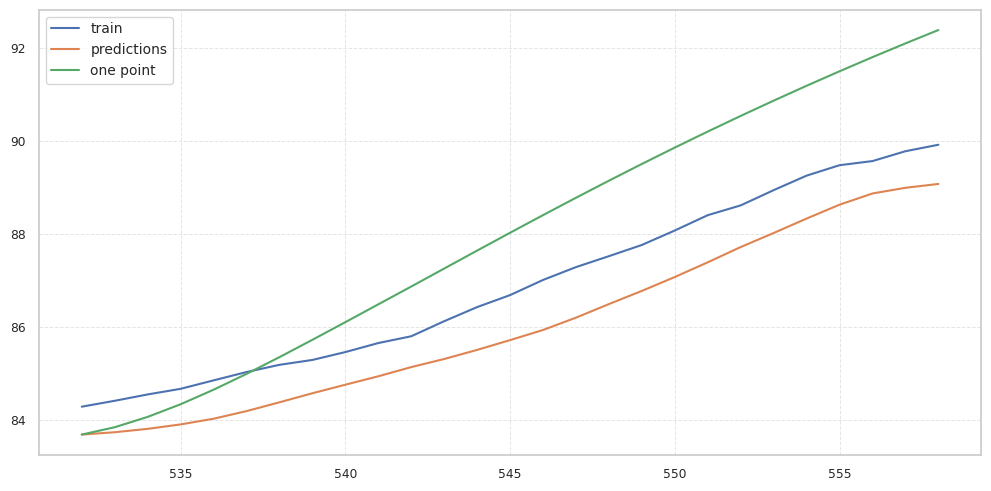

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(val[['MA28', 'preds28', 'preds_1_28']])
plt.legend(['train', 'predictions', 'one point'])
plt.show()